In [1]:
#Evaluate ACCESS-OM2-01 IAF Properties along 140E 
#https://cchdo.ucsd.edu/search?bbox=105,-90,115,-50

In [2]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath

In [3]:
client = Client(n_workers=8)
client

<Client: 'tcp://127.0.0.1:34633' processes=8 threads=8, memory=100.00 GiB>

In [4]:
#load woa13 data .... this needs improvment, see issues
#The initial condition we used for the new 0.1deg IAF runs is actually here:
#/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_temp_salt.res.nc
#So you should compare ocean_temp_salt.res.nc to the model field "temp" (which is conservative temperature), not "pot_temp". 
#Also in ocean_temp_salt.res.nc the upper 1500m is monthly January mean; below that is boreal winter mean. So you should compare with the model in January. Not sure if that helps much either, as your monthly climatologies look pretty similar.
woa13=xr.open_mfdataset('/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_temp_salt.res.nc',engine='netcdf4',decode_times=False)
#woa13.rename({'GRID_X_T': 'xt_ocean','GRID_Y_T': 'yt_ocean','ZT': 'st_ocean'})
woa13

#v2 this is in potential temp (should be conservative, but minor issure). Also 12 months of data ... not sure what decade
#woa13=xr.open_mfdataset('/g/data/hh5/tmp/cosima/woa13/01/output000/woa13_ts_*.nc',engine='netcdf4',decode_times=False)
woa13v2=xr.open_mfdataset('/g/data/hh5/tmp/cosima/woa13/01/output000/woa13_ts_*.nc',engine='netcdf4',decode_times=False)
#woa13v2.rename({'GRID_X_T': 'xt_ocean','GRID_Y_T': 'yt_ocean','ZT': 'st_ocean'})
woa13v2

<xarray.Dataset>
Dimensions:   (GRID_X_T: 3600, GRID_Y_T: 2700, ZT: 75, time: 12)
Coordinates:
  * GRID_X_T  (GRID_X_T) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * GRID_Y_T  (GRID_Y_T) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * ZT        (ZT) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * time      (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    temp      (time, ZT, GRID_Y_T, GRID_X_T) float64 dask.array<chunksize=(1, 75, 2700, 3600), meta=np.ndarray>
    salt      (time, ZT, GRID_Y_T, GRID_X_T) float64 dask.array<chunksize=(1, 75, 2700, 3600), meta=np.ndarray>

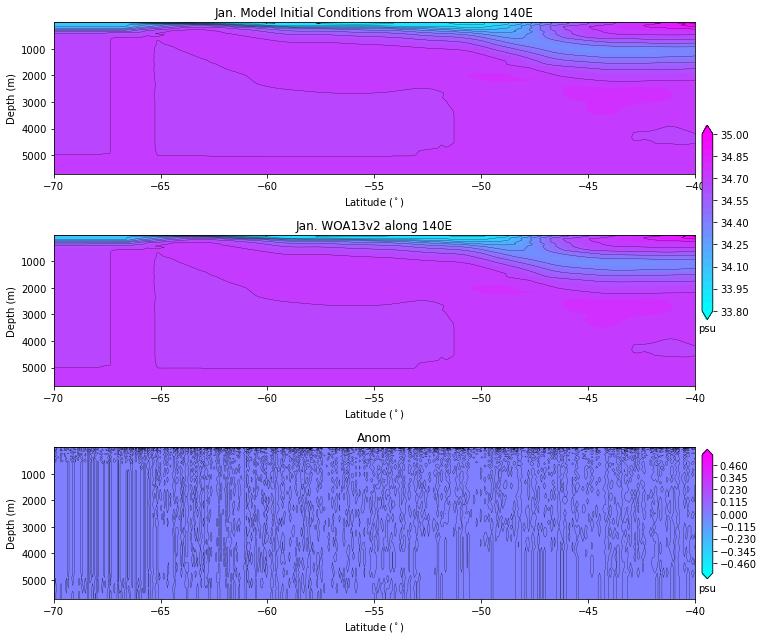

In [9]:
#check woa diffs
fig = plt.figure(figsize=(10, 9))

clev = np.arange(33.8,35.05,.05)
clev2 = np.arange(33.8,35,0.1)

lon1=-250

var=woa13.salt.sel(GRID_X_T=lon1, method='nearest')[0] #.mean(dim='time')

plt.subplot(3,1,1)
plt.gca().patch.set_color('.25')
#p1=plt.contourf(var.yt_ocean,var.st_ocean,var.values,levels=clev,cmap=plt.cm.cool,colobar=False,extend='both')
#plt.contour(var.yt_ocean,var.st_ocean,var.values,levels=clev2,colors='k',linewidths=0.25)
p1=plt.contourf(var.GRID_Y_T,var.ZT,var.values,levels=clev,cmap=plt.cm.cool,colobar=False,extend='both')
plt.contour(var.GRID_Y_T,var.ZT,var.values,levels=clev2,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-70,-40])
plt.title('Jan. Model Initial Conditions from WOA13 along 140E')

var=woa13v2.salt.sel(GRID_X_T=lon1, method='nearest')[0] #.mean(dim='time')

plt.subplot(3,1,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(var.GRID_Y_T,var.ZT,var.values,levels=clev,cmap=plt.cm.cool,colobar=False,extend='both')
plt.contour(var.GRID_Y_T,var.ZT,var.values,levels=clev2,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-70,-40])
plt.title('Jan. WOA13v2 along 140E')

#horiz, vert, width,height
ax = plt.axes([0.98,0.5,0.015,0.3])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.6)
cb.ax.set_xlabel('psu')

var=woa13v2.salt.sel(GRID_X_T=lon1, method='nearest')[0]-woa13.salt.sel(GRID_X_T=lon1, method='nearest')[0]

clev = np.arange(-.55,.555,.005)
clev2 = np.arange(-.55,.55,.01)

plt.subplot(3,1,3)
plt.gca().patch.set_color('.25')
p2=plt.contourf(var.GRID_Y_T,var.ZT,var.values,levels=clev,cmap=plt.cm.cool,colobar=False,extend='both')
plt.contour(var.GRID_Y_T,var.ZT,var.values,levels=clev2,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-70,-40])
plt.title('Anom')


#horiz, vert, width,height
ax = plt.axes([0.98,0.1,0.015,0.2])
cb = plt.colorbar(p2,cax=ax,orientation='vertical',shrink=0.6)
cb.ax.set_xlabel('psu')

plt.tight_layout()

In [5]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [20]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

cosima_cookbook.explore.DatabaseExplorer

In [21]:
ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v3_iaf')
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [7]:
expt='01deg_jra55v140_iaf_cycle3'
start = '2010-01-01 00:00:00'
end = '2018-12-31 00:00:00'
salt = cc.querying.getvar(expt, variable='salt', 
                       session=session, frequency='1 monthly',ncfile="%monthly-mean%",
                       start_time=start, 
                       end_time=end).sel(yt_ocean=slice(-90,-40)).sel(xt_ocean=slice(-260,-210)).sel(time=slice(start,end)).chunk({'st_ocean':25, 'xt_ocean':1800})

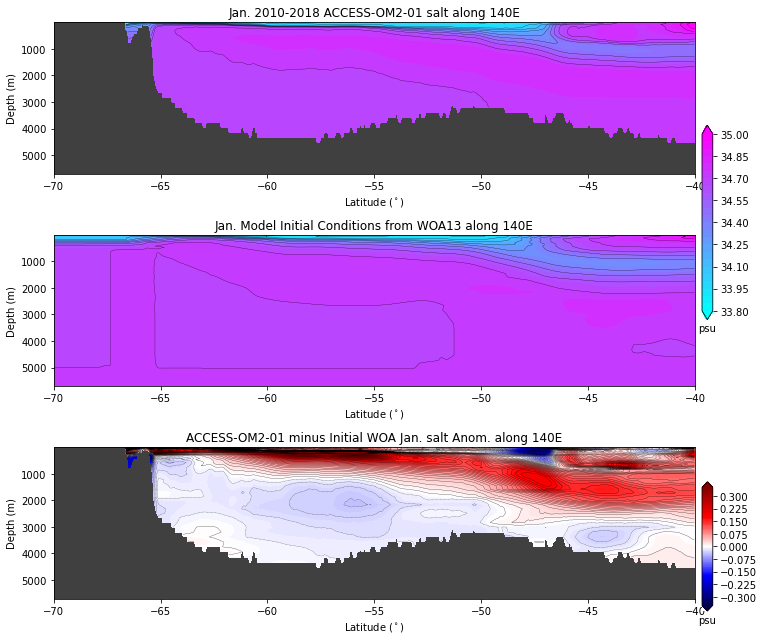

In [10]:
fig = plt.figure(figsize=(10, 9))

clev = np.arange(33.8,35.05,.05)
clev2 = np.arange(33.8,35,0.1)

var1=salt.sel(xt_ocean=lon1, method='nearest').groupby('time.month').mean(dim='time').compute()[0,:,:]

plt.subplot(3,1,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(var1.yt_ocean,var1.st_ocean,var1,levels=clev,cmap=plt.cm.cool,colobar=True,extend='both')
plt.contour(var1.yt_ocean,var1.st_ocean,var1,levels=clev2,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-70,-40])
plt.title('Jan. 2010-2018 ACCESS-OM2-01 salt along 140E')

var2=woa13.salt.sel(GRID_Y_T=slice(-90,-40)).sel(GRID_X_T=lon1, method='nearest').compute()[0] #.mean(dim='time')

plt.subplot(3,1,2)
plt.gca().patch.set_color('.25')
plt.contourf(var2.GRID_Y_T,var2.ZT,var2.values,levels=clev,cmap=plt.cm.cool,colobar=False,extend='both')
plt.contour(var2.GRID_Y_T,var2.ZT,var2.values,levels=clev2,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-70,-40])
plt.title('Jan. Model Initial Conditions from WOA13 along 140E')

#horiz, vert, width,height
ax = plt.axes([0.98,0.5,0.015,0.3])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('psu')

var=var1-var2.rename({'GRID_X_T': 'xt_ocean','GRID_Y_T': 'yt_ocean','ZT': 'st_ocean'})

clev = np.arange(-.35,.355,.005)
clev2 = np.arange(-.35,.35,.01)

plt.subplot(3,1,3)
plt.gca().patch.set_color('.25')
p2=plt.contourf(var.yt_ocean,var.st_ocean,var.values,levels=clev,cmap=plt.cm.seismic,colobar=False,extend='both')
plt.contour(var.yt_ocean,var.st_ocean,var,levels=clev2,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-70,-40])
plt.title('ACCESS-OM2-01 minus Initial WOA Jan. salt Anom. along 140E')


#horiz, vert, width,height
ax = plt.axes([0.98,0.05,0.015,0.2])
cb = plt.colorbar(p2,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('psu')

plt.tight_layout()

In [11]:
#longterm monthly mean data at 140E
var=salt.sel(xt_ocean=lon1, method='nearest').groupby('time.month').mean(dim='time') #.resample({'time':'M'})
var

<xarray.DataArray 'salt' (month: 12, st_ocean: 75, yt_ocean: 808)>
dask.array<stack, shape=(12, 75, 808), dtype=float32, chunksize=(1, 25, 135), chunktype=numpy.ndarray>
Coordinates:
    xt_ocean  float64 -250.0
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -40.18 -40.11 -40.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

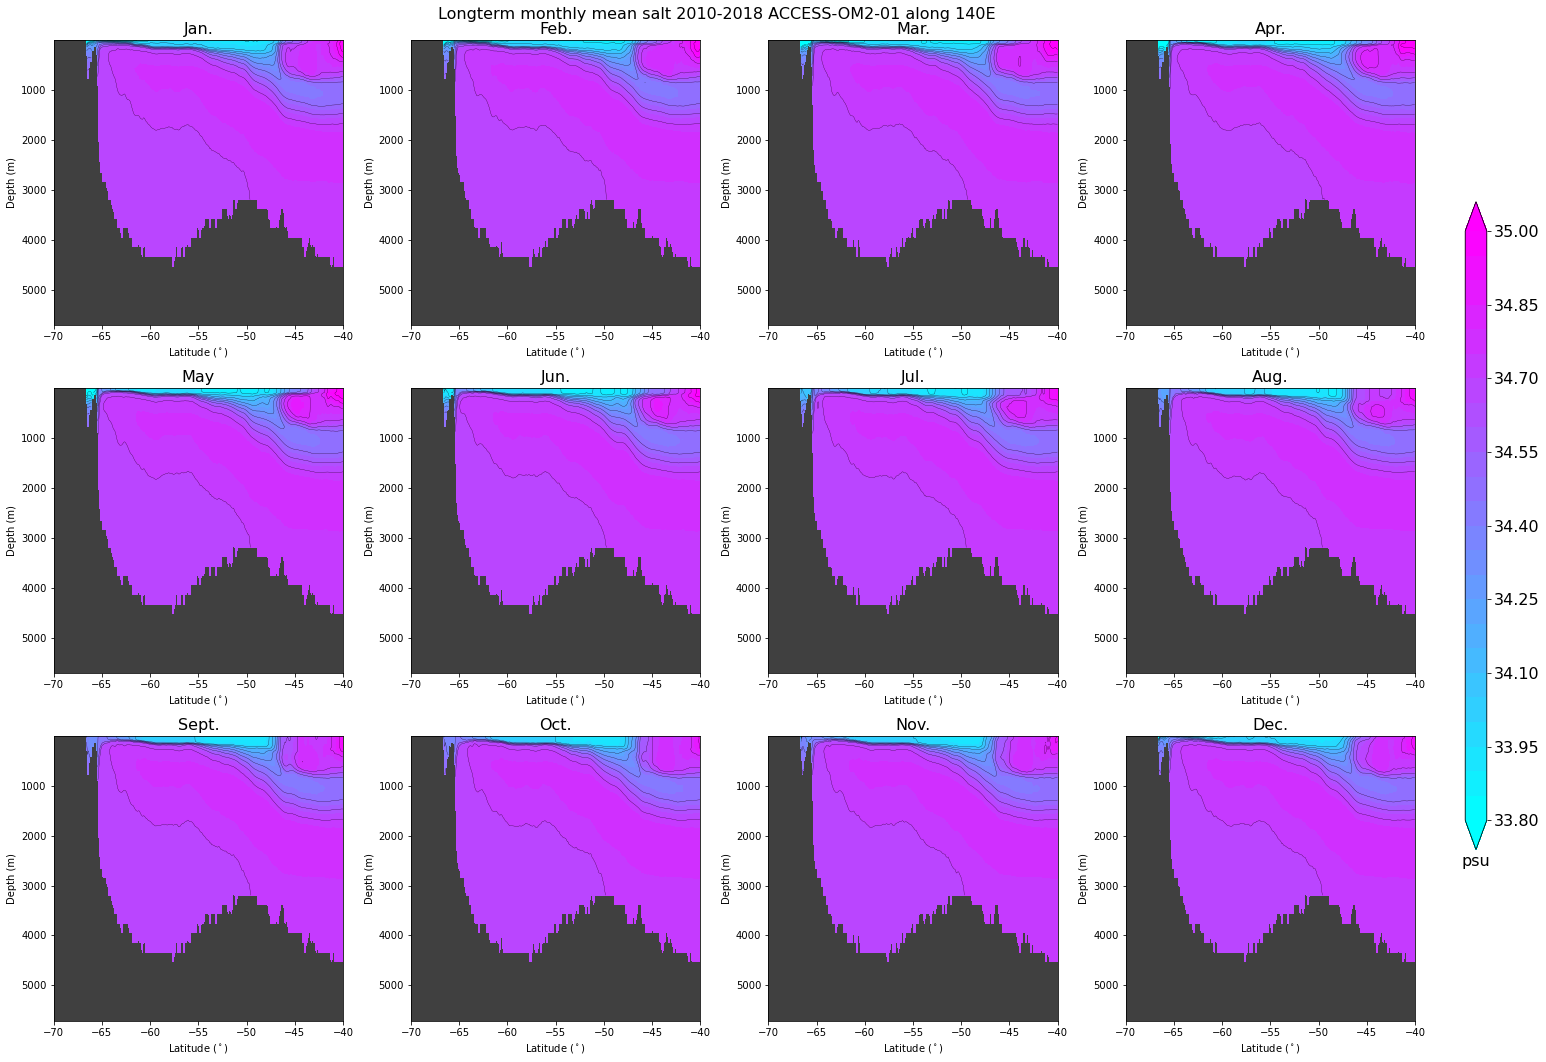

In [12]:
clev = np.arange(33.8,35.05,.05)
clev2 = np.arange(33.8,35,0.1)

mnth=['Jan.', 'Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.']
plt.figure(figsize=(20,15))
plt.suptitle('Longterm monthly mean salt 2010-2018 ACCESS-OM2-01 along 140E',fontsize = 16)

for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(var.yt_ocean,var.st_ocean,var[i,:,:],levels=clev,cmap=plt.cm.cool,colobar=True,extend='both')
    plt.contour(var.yt_ocean,var.st_ocean,var[i,:,:],levels=clev2,colors='k',linewidths=0.25)
    plt.gca().invert_yaxis()
    #plt.ylim((1037.5,1034))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-70,-40])
    plt.title(mnth[i],fontsize = 16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('psu',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()

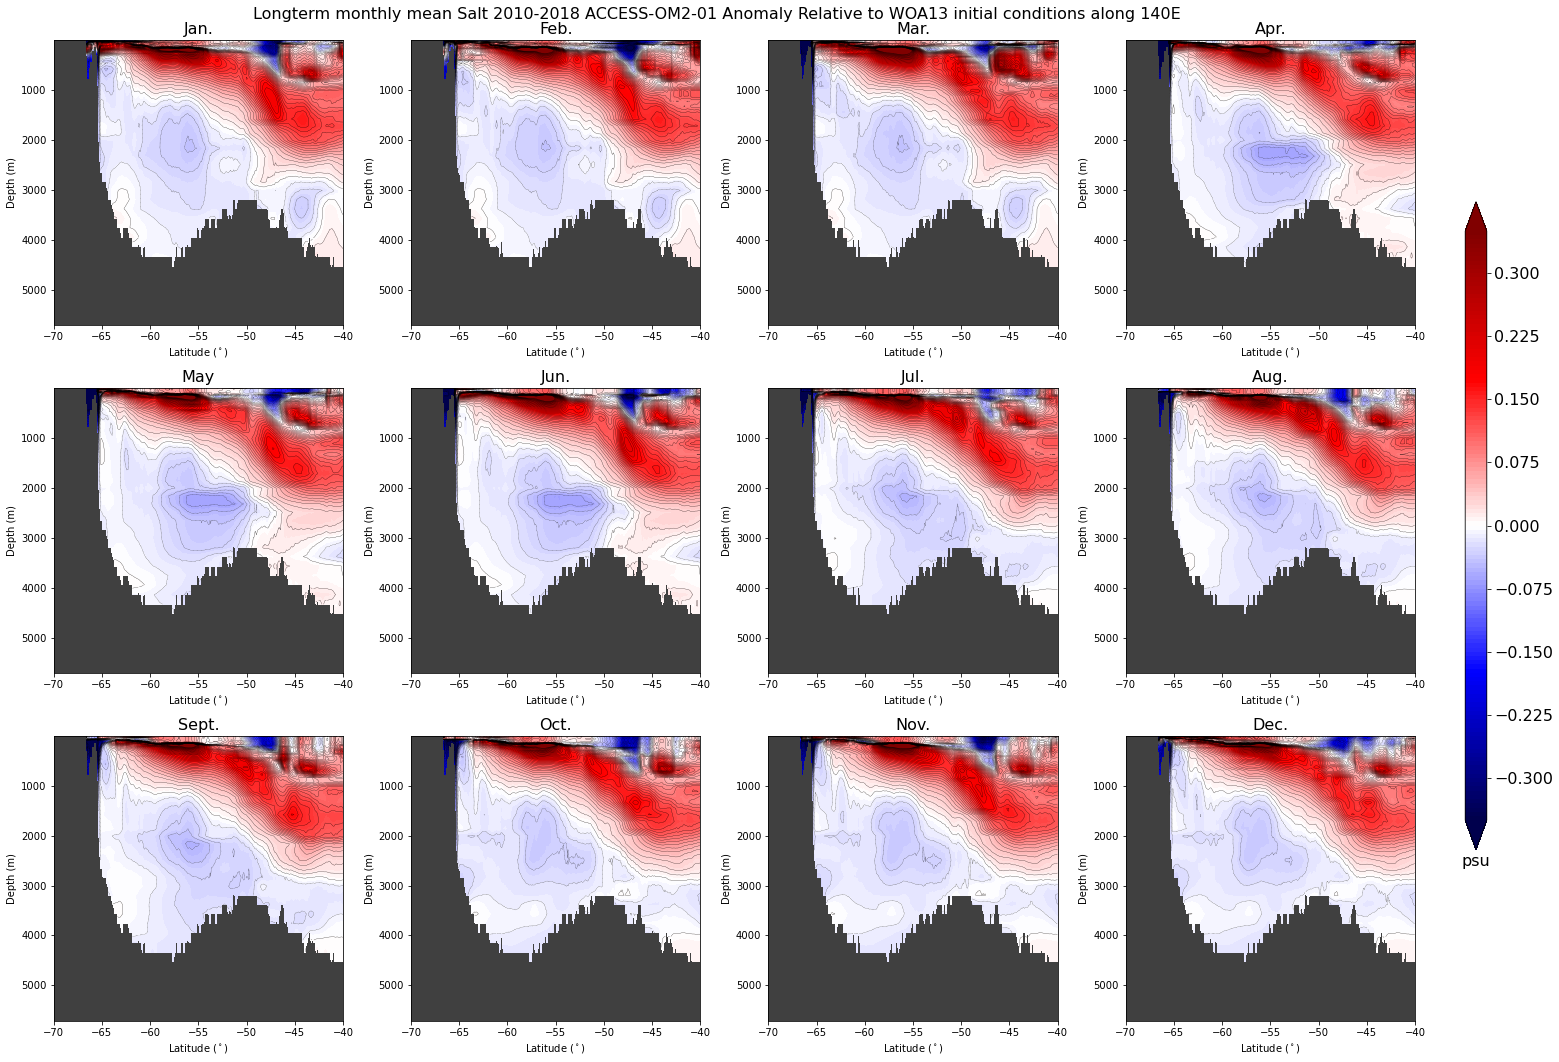

In [13]:
var1=salt.sel(xt_ocean=lon1, method='nearest').groupby('time.month').mean(dim='time').compute()
var2=woa13v2.salt.sel(GRID_Y_T=slice(-90,-40)).sel(GRID_X_T=lon1, method='nearest').compute() #.mean(dim='time')

var=var1-var2.rename({'GRID_X_T': 'xt_ocean','GRID_Y_T': 'yt_ocean','ZT': 'st_ocean','time': 'month'})

clev = np.arange(-.35,.355,.005)
clev2 = np.arange(-.35,.35,.01)

mnth=['Jan.', 'Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.']
plt.figure(figsize=(20,15))
plt.suptitle('Longterm monthly mean Salt 2010-2018 ACCESS-OM2-01 Anomaly Relative to WOA13 initial conditions along 140E',fontsize = 16)

for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(var.yt_ocean,var.st_ocean,var[i,:,:],levels=clev,cmap=plt.cm.seismic,colobar=True,extend='both')
    plt.contour(var.yt_ocean,var.st_ocean,var[i,:,:],levels=clev2,colors='k',linewidths=0.25)
    plt.gca().invert_yaxis()
    #plt.ylim((1037.5,1034))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-70,-40])
    plt.title(mnth[i],fontsize = 16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('psu',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()

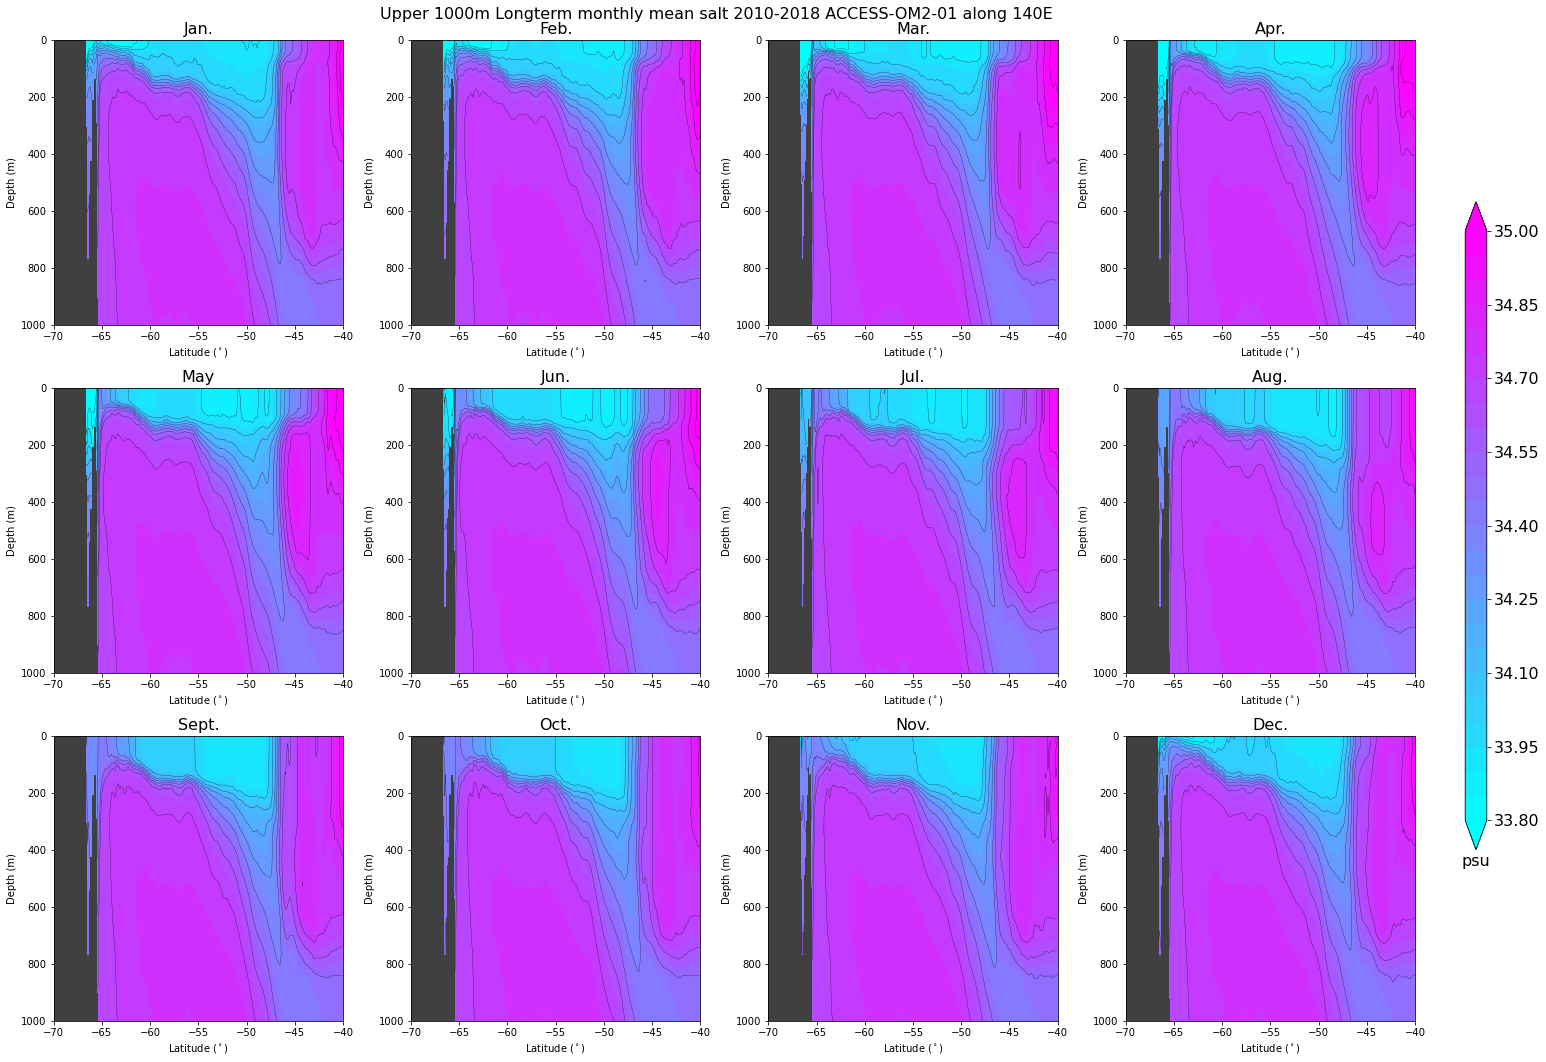

In [14]:
clev = np.arange(33.8,35.05,.05)
clev2 = np.arange(33.8,35,0.1)

mnth=['Jan.', 'Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.']
plt.figure(figsize=(20,15))
plt.suptitle('Upper 1000m Longterm monthly mean salt 2010-2018 ACCESS-OM2-01 along 140E',fontsize=16)

for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(var.yt_ocean,var.st_ocean,var1[i,:,:],levels=clev,cmap=plt.cm.cool,colobar=True,extend='both')
    plt.contour(var.yt_ocean,var.st_ocean,var1[i,:,:],levels=clev2,colors='k',linewidths=0.25)
    #plt.ylim((1037.5,1034))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-70,-40])
    plt.ylim([0,1000])
    plt.gca().invert_yaxis()
    plt.title(mnth[i],fontsize=16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('psu',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()

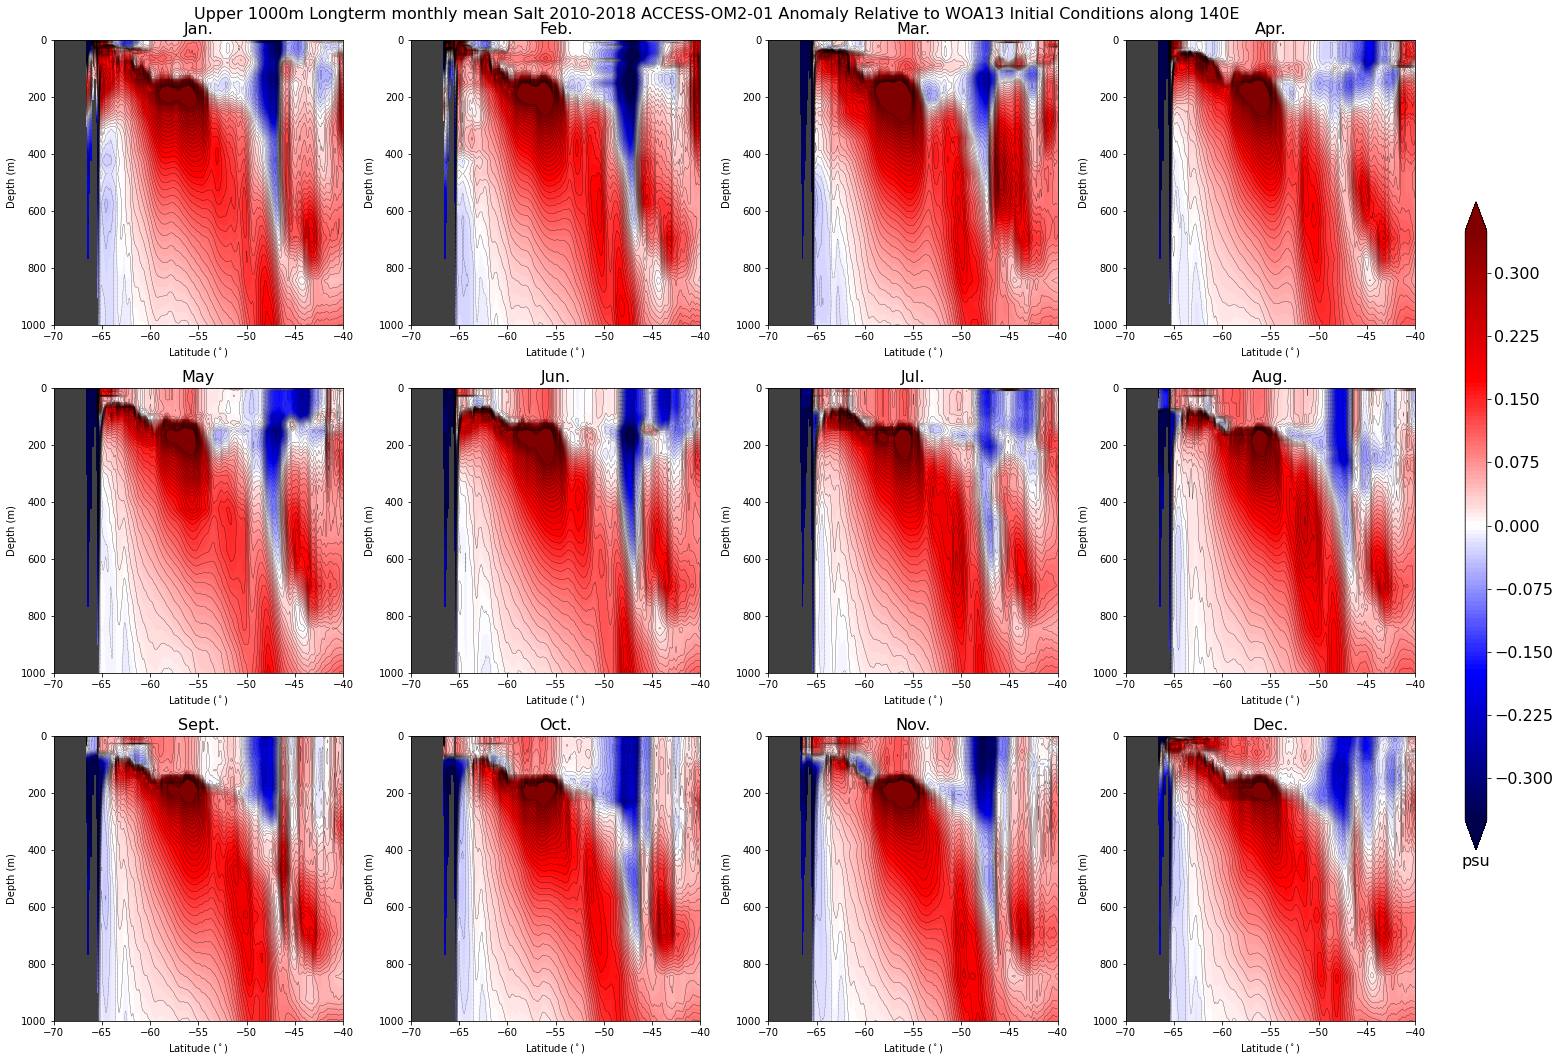

In [15]:
clev = np.arange(-.35,.355,.005)
clev2 = np.arange(-.35,.35,.01)

mnth=['Jan.', 'Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.']
plt.figure(figsize=(20,15))
plt.suptitle('Upper 1000m Longterm monthly mean Salt 2010-2018 ACCESS-OM2-01 Anomaly Relative to WOA13 Initial Conditions along 140E',fontsize=16)

for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(var.yt_ocean,var.st_ocean,var[i,:,:],levels=clev,cmap=plt.cm.seismic,colobar=True,extend='both')
    plt.contour(var.yt_ocean,var.st_ocean,var[i,:,:],levels=clev2,colors='k',linewidths=0.25)
    #plt.ylim((1037.5,1034))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-70,-40])
    plt.ylim([0,1000])
    plt.gca().invert_yaxis()
    plt.title(mnth[i],fontsize=16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('psu',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()